In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt as pw

In [2]:
data = pd.read_excel("data.xlsx", sheet_name="0-sitting",
                     header=0, usecols="B:F")
data = data[0]
data = (data - min(data)) / (max(data) - min(data))
ecg = data.T.values.tolist()

D:\Scoop\apps\anaconda3\current\lib\site-packages\pandas\io\excel\_base.py:1272: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  return self._reader.parse(


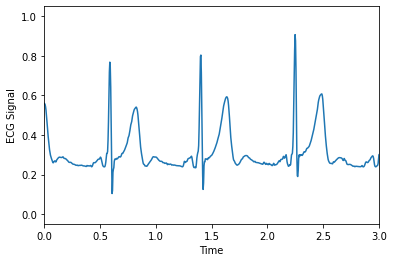

In [3]:
import wavelet_filter as filter
from ecg_gudb_database import GUDb
sample_rate = GUDb.fs
t = np.arange(len(ecg)) / float(sample_rate)
filtered = filter.wavelet_filtering(data)
plt.xlabel('Time')
plt.ylabel('ECG Signal')
plt.xlim(0, 3)
plt.plot(t, filtered)

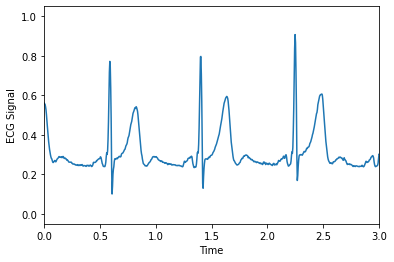

In [6]:
plt.xlabel('Time')
plt.ylabel('ECG Signal')
ecg = np.array(ecg)
t = np.arange(len(ecg)) / float(250)
ecg = (ecg - min(ecg)) / (max(ecg) - min(ecg))
plt.xlim(0, 3)
plt.plot(t, ecg)

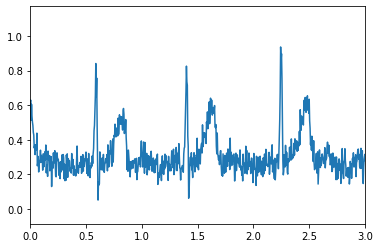

In [3]:
data += np.random.normal(0, 0.05, (data.shape))
t = np.arange(len(data)) / float(250)
plt.xlim(0, 3)
plt.plot(t, data)

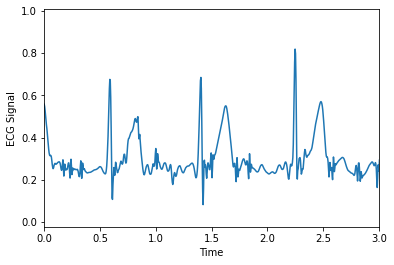

In [4]:
import wavelet_filter as filter
from ecg_gudb_database import GUDb
sample_rate = GUDb.fs
filtered = filter.wavelet_filtering(data)
plt.xlabel('Time')
plt.ylabel('ECG Signal')
plt.xlim(0, 3)
plt.plot(t, filtered)

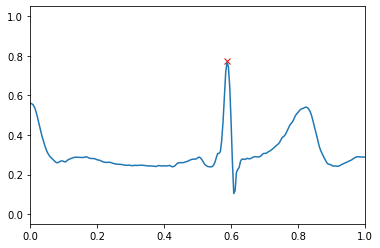

In [7]:
from qrs_detect_demo import QRS_detection as detect
spot = detect(filtered, GUDb.fs, 160)
spot_t = []
spot_r = []
for i in spot:
    spot_t.append(t[i])
for i in spot:
    spot_r.append(ecg[i])
plt.xlim(0, 1)
plt.plot(spot_t, spot_r, 'x', color='r')
plt.plot(t, filtered)

In [24]:
pw.swt_max_level(len(ecg))

4

In [6]:
(cA4, cD4), (cA3, cD3), (cA2, cD2), (cA1, cD1) = pw.swt(ecg, wavelet="haar", level=4)

Text(0.5, 0.98, 'Detail Coefficents Use Haar Wavelet Base')

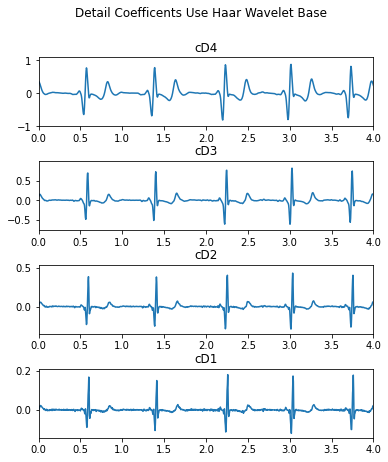

In [57]:
plt.figure(figsize=(6, 7))
plt.subplots_adjust(hspace =0.5)
plt.subplot(411)
plt.xlim(0, 4)
plt.title("cD4")
plt.plot(t, cD4)

plt.subplot(412)
plt.xlim(0, 4)
plt.title("cD3")
plt.plot(t, cD3)

plt.subplot(413)
plt.xlim(0, 4)
plt.title("cD2")
plt.plot(t, cD2)

plt.subplot(414)
plt.xlim(0, 4)
plt.title("cD1")
plt.plot(t, cD1)

plt.suptitle("Detail Coefficents Use Haar Wavelet Base")


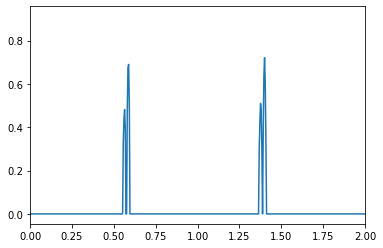

In [13]:
avg = np.mean(cD3)
std = np.std(cD3)
sig_thres = [abs(i) if abs(i) > 2.0*std else 0 for i in cD3-avg]
plt.xlim(0, 2)
plt.plot(t, sig_thres)

In [31]:
m = []
m.append((10, 2))
m.append((3, 4))
for i, loc in enumerate(m):
    print(loc + 1)

TypeError: can only concatenate tuple (not "int") to tuple